# Gaussian Process Regression on a Mesh with **GPJax**

This notebooks shows how to fit a [GPJax](https://jaxgaussianprocesses.com/) Gaussian process (GP) on a mesh.

In [1]:
# Import a backend, we use jax in this example.
import jax.numpy as jnp
import jax
import gpjax as gpx

# Import the geometric_kernels backend.
import geometric_kernels
import geometric_kernels.jax

# Import the Mesh space and the general-purpose MaternGeometricKernel
from geometric_kernels.spaces.mesh import Mesh
from geometric_kernels.kernels import MaternGeometricKernel

# The GPflow frontend of GeometricKernels
from geometric_kernels.frontends.jax.gpjax import GPJaxGeometricKernel

# Sampling routines we will use to create a dummy dataset
from geometric_kernels.kernels import default_feature_map
from geometric_kernels.sampling import sampler
from geometric_kernels.utils.utils import make_deterministic

# Stuff
import numpy as np
import optax
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path

jax.config.update("jax_enable_x64", True)

/Users/vabor112/anaconda3/envs/gkconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO: Using numpy backend


## Mesh Plotting Utils for `plotly`

In [2]:
def update_figure(fig):
    """Utility to clean up figure"""
    fig.update_layout(scene_aspectmode="cube")
    fig.update_scenes(xaxis_visible=False, yaxis_visible=False, zaxis_visible=False)
    # fig.update_traces(showscale=False, hoverinfo="none")
    fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))

    fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", paper_bgcolor="rgba(0,0,0,0)")
    fig.update_layout(
        scene=dict(
            xaxis=dict(showbackground=False, showticklabels=False, visible=False),
            yaxis=dict(showbackground=False, showticklabels=False, visible=False),
            zaxis=dict(showbackground=False, showticklabels=False, visible=False),
        )
    )
    return fig

def plot_mesh(mesh: Mesh, vertices_colors = None, **kwargs):
    plot = go.Mesh3d(
        x=mesh.vertices[:, 0],
        y=mesh.vertices[:, 1],
        z=mesh.vertices[:, 2],
        i=mesh.faces[:, 0],
        j=mesh.faces[:, 1],
        k=mesh.faces[:, 2],
        colorscale='viridis',
        intensity=vertices_colors,
        **kwargs
    )
    return plot

## Defining a Space

First, we create a GeometricKernels space that corresponds to a teddy bear mesh loaded from "../data/teddy.obj"

In [3]:
mesh = Mesh.load_mesh(str(Path.cwd().parent / "data" / "teddy.obj"))
print("Number of vertices in the mesh:", mesh.num_vertices)

Number of vertices in the mesh: 1598


Now we actually visualize the mesh.

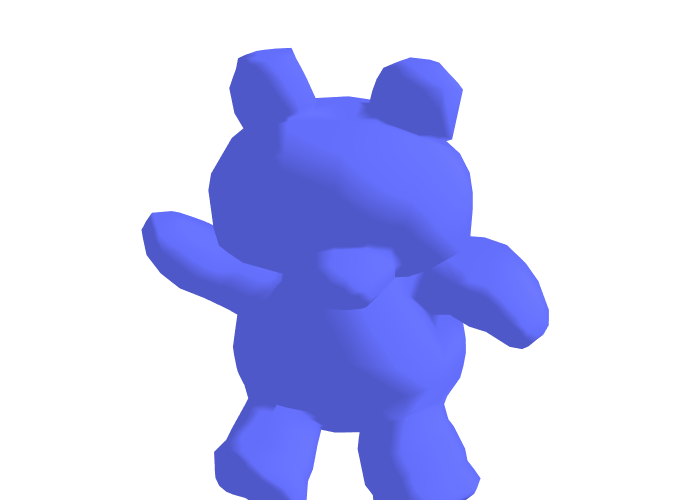

In [4]:
# Define the camera
camera = dict(
    up=dict(x=0, y=1, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=0.7, z=1.25)
)

plot = plot_mesh(mesh)
fig = go.Figure(plot)
update_figure(fig)
fig.update_layout(
    scene_camera=camera
)
fig.show('png')

## Create a Dummy Dataset on the Mesh

We sample from the prior of a GP to create a simple dataset we can afterwards fit using an exact Gaussian process regression (GPR) model.

The input set $X \in \mathbb{N}^{n \times 1}$ consists of **indices** enumerating vertices of the mesh. Consequently, the elements of $X$ are in $[0, N_v-1]$, where $N_v$ are the number of vertices in the mesh.
We sample `num_data` of them into the tensor called `xs_train`. For test inputs `xs_test`, we use the whole $X$.

In [5]:
num_data = 25
key = jax.random.PRNGKey(1234)

xs_train = jax.random.randint(key, minval=0, maxval=mesh.num_vertices, shape=(num_data, 1), dtype=jnp.int64)
xs_test = jnp.arange(mesh.num_vertices, dtype=jnp.int64)[:, None]
print('xs_train:', xs_train)
# print('xs_test:', xs_test)

xs_train: [[ 945]
 [ 844]
 [1337]
 [1289]
 [ 145]
 [1142]
 [ 934]
 [1455]
 [1408]
 [1351]
 [ 607]
 [ 927]
 [1038]
 [ 181]
 [ 975]
 [1478]
 [1186]
 [1555]
 [ 836]
 [ 223]
 [ 382]
 [1503]
 [1023]
 [ 891]
 [1036]]


To generate the corresponding outputs `ys_train` and `ys_test`, we sample from the prior. To do this, we create a `MaternGeometricKernel` object and use the efficent sampling functionality of GeometricKernels.

In [6]:
base_kernel = MaternGeometricKernel(mesh)

params = base_kernel.init_params()
params["lengthscale"] = jnp.array([2.0], dtype=jnp.float64)
params["nu"]  = jnp.array([2.5], dtype=jnp.float64)

feature_map = default_feature_map(kernel=base_kernel)
sample_paths = make_deterministic(sampler(feature_map), key)

_, ys_train  = sample_paths(xs_train, params)
key, ys_test = sample_paths(xs_test,  params)
assert(jnp.allclose((ys_test[xs_train])[:, :, 0], ys_train))

# print('ys_train:', ys_train)
# print((ys_test[xs_train])[:, :, 0])

/Users/vabor112/anaconda3/envs/gkconda/lib/python3.10/site-packages/beartype/_util/hint/pep/utilpeptest.py:347: BeartypeDecorHintPep585DeprecationWarning:

PEP 484 type hint typing.List deprecated by PEP 585. This hint is scheduled for removal in the first Python version released after October 5th, 2025. To resolve this, import this hint from "beartype.typing" rather than "typing". For further commentary and alternatives, see also:
    https://beartype.readthedocs.io/en/latest/api_roar/#pep-585-deprecations



## Build a GPJax Model

Now we wrap the `base_kernel` created above into the `GPJaxGeometricKernel` to make an actual GPJax kernel.

**Note:** `params` are external to the `base_kernel` object, thus we need to pass them to the `GPJaxGeometricKernel` explicitly.
Otherwise it will use `params = base_kernel.init_params()`.

In [7]:
kernel = GPJaxGeometricKernel(base_kernel=base_kernel,
                                        nu=params["nu"],
                                        lengthscale=params["lengthscale"],
                                        variance=1.0)

# Comment out the line below if you want optimizable nu.
# Note: if nu is initialized to jnp.inf, it will not be optimizable either way.
kernel = kernel.replace_trainable(nu=False)
print('Info on Trainable Parameters:', kernel.trainables())

Info on Trainable Parameters: GPJaxGeometricKernel(active_dims=None, name='Geometric Kernel', nu=False, lengthscale=True, variance=True, base_kernel=<geometric_kernels.kernels.geometric_kernels.MaternKarhunenLoeveKernel object at 0x174bcd960>)


We use the data `xs_train`, `ys_train` and the GPJax kernel `kernel` to construct a GPJax model.

In [8]:
data = gpx.Dataset(X=xs_train, y=ys_train)

prior = gpx.Prior(mean_function=gpx.mean_functions.Zero(), kernel=kernel)

likelihood = gpx.likelihoods.Gaussian(num_datapoints=num_data)

posterior = likelihood * prior

print('Initial model:')
print('kernel.nu =', prior.kernel.nu)
print('kernel.lengthscale =', prior.kernel.lengthscale)
print('kernel.variance =', prior.kernel.variance)
print('likelihood.obs_noise =', likelihood.obs_noise)
print('')

negative_mll = gpx.objectives.ConjugateMLL(negative=True)
print("Initial negative log marginal likelihood:", negative_mll(posterior, train_data=data))

Initial model:
kernel.nu = inf
kernel.lengthscale = 1.0
kernel.variance = 1.0
likelihood.obs_noise = 1.0



/Users/vabor112/anaconda3/envs/gkconda/lib/python3.10/site-packages/gpjax/dataset.py:58: UserWarning:

X is not of type float64. Got X.dtype=int64. This may lead to numerical instability. 



Initial negative log marginal likelihood: 34.14773896306096


## Train the Model (Optimize Hyperparameters)

In [9]:
negative_mll = jax.jit(negative_mll)

print('Starting training...')
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=data,
    optim=optax.sgd(0.01),
    key=key,
)
print('Final model:')
print('kernel.nu =', opt_posterior.prior.kernel.nu)
print('kernel.lengthscale =', opt_posterior.prior.kernel.lengthscale)
print('kernel.variance =', opt_posterior.prior.kernel.variance)
print('likelihood.obs_noise =', opt_posterior.likelihood.obs_noise)
print('')

print("Final negative log marginal likelihood:", negative_mll(opt_posterior, train_data=data))

Starting training...


Running: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 280.66it/s, Value=29.62]

Final model:
kernel.nu = inf
kernel.lengthscale = 1.343590471604602
kernel.variance = 0.5424985
likelihood.obs_noise = 0.31390566

Final negative log marginal likelihood: 29.583547404297107


## Draw Predictions and Evaluate the Model

Recall that `xs_test` contains all the locations on the mesh, i.e. all numbers from the set $\{0, 1, \ldots, N_v-1\}$.

In [10]:
# predict mean and variance
latent_dist = opt_posterior.predict(xs_test, train_data=data)
posterior_mean = jnp.reshape(latent_dist.mean(), ys_test.shape)
posterior_std = jnp.reshape(latent_dist.stddev(), ys_test.shape)

# predict sample
sample = latent_dist.sample(seed=key, sample_shape=(1,))[0, :, None]

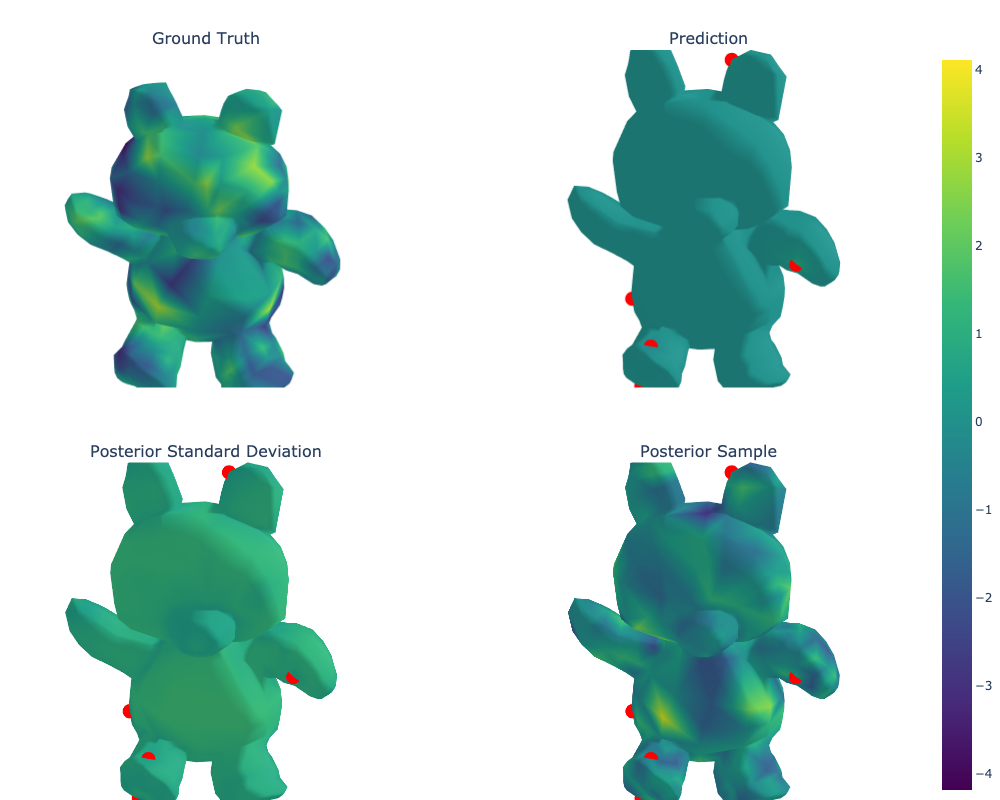

In [11]:
# Mark training data
training_data_coords = mesh.vertices[xs_train[:, 0]]

training_data_plot  = go.Scatter3d(
    x=np.array(training_data_coords[:, 0]),
    y=np.array(training_data_coords[:, 1]),
    z=np.array(training_data_coords[:, 2]),
    mode = 'markers',
    marker_color = 'red',
    name=''
)

# Various plots as plotly traces
ground_truth_plot   = plot_mesh(mesh, vertices_colors=ys_test,        coloraxis = "coloraxis")
posterior_mean_plot = plot_mesh(mesh, vertices_colors=posterior_mean, coloraxis = "coloraxis")
posterior_std_plot  = plot_mesh(mesh, vertices_colors=posterior_std,  coloraxis = "coloraxis")
sample_plot         = plot_mesh(mesh, vertices_colors=sample,         coloraxis = "coloraxis")

# Setting up the layout
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=(r"Ground Truth",
                    r"Prediction",
                    r"Posterior Standard Deviation",
                    r"Posterior Sample"),
    vertical_spacing=0.1)

# Adding the traces
fig.add_trace(ground_truth_plot,   row=1, col=1)

fig.add_trace(training_data_plot,  row=1, col=2)
fig.add_trace(posterior_mean_plot, row=1, col=2)

fig.add_trace(training_data_plot,  row=2, col=1)
fig.add_trace(posterior_std_plot,  row=2, col=1)

fig.add_trace(training_data_plot,  row=2, col=2)
fig.add_trace(sample_plot,         row=2, col=2)

fig = update_figure(fig)

fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera
fig.layout.scene4.camera = camera


fig.update_layout(
    margin={'t': 50},
    coloraxis = {'colorscale':'viridis'},
)

fig.show('png', width=1000, height=800)